# ML analysis of 3' and 5' UTR sequences

In [ ]:
#we import a dataset of newly re-annotated UTR sequences
import pandas as pd
import numpy as np
df = pd.read_csv('df_seq.csv',index_col=[0])
df.head()

,gene_id,utr_5,utr_3,utr_5_seq,utr_3_seq
0,Tb927.9.13440,Tb927_09_v5.1:2132976..2133162:r,Tb927_09_v5.1:2127479..2128238:r,ATAGGGCAGAGATAAGAAAGAACAAAAGTGACTAACGTCATCGGAA...,CGGGAGCGGGAGAGTAATAACTAGAGAAAGAAAAGAAATAGAGGAC...
1,Tb927.9.13430,Tb927_09_v5.1:2126776..2127309:r,Tb927_09_v5.1:2121838..2125437:r,GGGAAGGTTCTCATTAAGCGGAAGATAGGGGGAACCAGACCCTCCA...,AGAATGATAATGATGGAGGGGTTGGGAAGAAGGGGGAGACATTTGT...
2,Tb927.9.13380,Tb927_09_v5.1:2120866..2121171:r,Tb927_09_v5.1:2118125..2119605:r,GAATCATTTTTAAAAAAAATTAGATTTGCAGTGTTGAAGTGTTTTC...,GTAATAATGGAAAAAAAAAAGAAGAATGGTGGGAGGAAGAAAAGGA...
3,Tb927.9.13360,Tb927_09_v5.1:2117171..2117516:r,Tb927_09_v5.1:2108712..2111431:r,TAACAACAAAGAGAATATATATCTCTAAATATATATTCATATATTT...,GTAATGTAGAAGGGCACTGTGCGATCAGTCTTGCTTTTTATTATTA...
4,Tb927.9.8905,Tb927_09_v5.1:1431796..1431807:r,Tb927_09_v5.1:1431368..1431516:r,GATATCGGCAGG,ACTTTTTGGCTGCCTCTTTCGCACCATTTTTTTGAGTTCGCGTTGT...


## Feature extraction
we create a class to extract features from DNA sequences

In [ ]:
import re  # Import the regular expressions module for pattern matching within strings.
class ExtractDNAFeatures:
    '''
    The class extract featurs from DNA sequences.
    These features include base counts, counts of specific base tracts 
    considering mismatches, and the sequence length. Each feature is normalized
    by the sequence length to provide relative values, making it easier to 
    compare sequences of different lengths. The method returns a dictionary with 
    the DNA sequence ID as the key and the features dictionary as the value, 
    allowing for easy identification and association of the extracted 
    features with the specific DNA sequence.    
    '''
    def __init__(self, dna_sequence, dna_sequence_id):
        # Initializer method that sets up the DNA sequence, its ID, and calculates its length.
        self.dna_sequence = dna_sequence  # Store the DNA sequence.
        self.dna_sequence_id = dna_sequence_id  # Store the ID associated with the DNA sequence.
        self.sequence_length = len(dna_sequence)  # Calculate and store the length of the DNA sequence.

    def base_count(self):
        # Counts the occurrences of each base in the DNA sequence and calculates some combined counts.
        base_counts = {'A': 0, 'T': 0, 'C': 0, 'G': 0}  # Initialize a dictionary to store counts for each base.

        for base in self.dna_sequence:  # Iterate through each base in the sequence.
            if base in base_counts:  # If the base is one of the recognized bases (A, T, C, G),
                base_counts[base] += 1  # increment its count in the dictionary.

        # Calculate combined counts for AT, CG, CT, and AG pairs.
        base_counts['AT'] = base_counts['A'] + base_counts['T']
        base_counts['CG'] = base_counts['C'] + base_counts['G']
        base_counts['CT'] = base_counts['C'] + base_counts['T']
        base_counts['AG'] = base_counts['A'] + base_counts['G']
        
        return base_counts  # Return the dictionary containing all the counts.

    def count_tracts(self, pattern, min_length=5):
        # Counts the number of tracts (continuous sequences) of a given pattern within the DNA sequence.
        regex_pattern = '[' + pattern + ']{' + str(min_length) + ',}'  # Construct a regex pattern to find tracts of the specified pattern with a minimum length.
        tracts = re.findall(regex_pattern, self.dna_sequence)  # Find all matching tracts in the DNA sequence.
        return len(tracts)  # Return the number of tracts found.

    def longest_tract_length(self, pattern, min_length=5, max_mismatch=0):
        # Finds the longest tract of a given pattern in the DNA sequence, allowing for a specified number of mismatches.
        regex_pattern = '[' + pattern + ']{' + str(min_length) + ',}'  # Construct a regex pattern similar to `count_tracts`.
        tracts = list(re.finditer(regex_pattern, self.dna_sequence))  # Find all matching tracts using iterators for more detailed info.

        if len(tracts) == 0:  # If no tracts are found,
            return 0, None, 0  # return zeros for length and count, and None for the start index.

        # Process tracts to account for mismatches.
        tracts_indexes = [(x.start(), x.end()) for x in tracts]  # Get start and end indexes of each tract.
        new_tracts_indexes = []  # Initialize a list to store processed tracts considering mismatches.
        current_tract = tracts_indexes[0]  # Start with the first tract.

        # Iterate through the tracts to merge those that are within the max_mismatch distance.
        for i in range(1, len(tracts_indexes)):
            if tracts_indexes[i][0] - current_tract[1] <= max_mismatch:  # If the next tract is within the allowed mismatch distance,
                current_tract = (current_tract[0], tracts_indexes[i][1])  # extend the current tract.
            else:  # Otherwise,
                new_tracts_indexes.append(current_tract)  # finalize the current tract and start a new one.
                current_tract = tracts_indexes[i]

        new_tracts_indexes.append(current_tract)  # Add the last tract after the loop.
        longest_tract = max(new_tracts_indexes, key=lambda x: x[1] - x[0])  # Find the longest tract.
        longest_length = longest_tract[1] - longest_tract[0]  # Calculate the length of the longest tract.
        start_index = longest_tract[0]  # Get the start index of the longest tract.
        
        return longest_length, start_index, len(new_tracts_indexes)  # Return the length, start index, and count of processed tracts.

    def count_motif(self, motif='AAGAAAA'):
        # Counts occurrences of a specific motif within the DNA sequence.
        return len(re.findall(motif, self.dna_sequence))  # Use regex to find all occurrences of the motif and return the count.

    def get_features(self):
        # Extracts a comprehensive set of features from the DNA sequence.
        base_counts = self.base_count()  # Get the base counts using the previously defined method.
        # Initialize a dictionary to store features, starting with base counts.
        features = {'count_' + key: value for key, value in base_counts.items()}
        
        # For selected bases and combinations, calculate the number of tracts considering mismatches.
        for base in ['A', 'C', 'CT', 'AG']:
            for max_mismatch in [2, 1, 0]:  # Iterate over different max_mismatch values.
                count_tracts = self.longest_tract_length(base, max_mismatch=max_mismatch)  # Get tract count with mismatches.
                # Store the count of tracts with the current base and mismatch level.
                features[f'count_tracts_{base}_mismatch_{max_mismatch}'] = count_tracts[2]

        # Normalize feature values by dividing by the DNA sequence length to get relative values.
        for key in features:
            features[key] /= self.sequence_length

        # Uncomment to include the count of a specific motif ('AAGAAAA') in the features.
        # features['count_motif_AAGAAAA'] = self.count_motif('AAGAAAA')

        features['seq_len'] = self.sequence_length  # Add the sequence length as a feature.

        return {self.dna_sequence_id: features}  # Return the features dictionary, keyed by the DNA sequence ID.


In [ ]:
#select UTRs sequences for analysis, threshold at 20 nucleotides for 3' UTRs
print(df.shape)
df=df[df['utr_3_seq'].str.len()>20]
print(df.shape)

(8261, 5)
(7994, 5)


In [ ]:
#using this resource:
# https://tbrucei-ibaq-927.pages.dev/
#we filter out developmental regualted genes
#expressed preferantially in PCF or BSF
filter_out = pd.read_csv('927 iBAQ.csv')
filter_1=set(filter_out[(filter_out['bsf']>4) & (filter_out['pcf']<4)]['Gene_id'])
filter_2=set(filter_out[(filter_out['bsf']<4) & (filter_out['pcf']>4)]['Gene_id'])
filter_out = list(filter_1)+list(filter_2)
len(filter_out)

2027

In [ ]:
print(df.shape)
df=df[~df['gene_id'].isin(filter_out)]
print(df.shape)

(7994, 5)
(6214, 5)


In [ ]:
#we create a fasta file from 3' UTR sequences
infile = open('infasta3utrs.fa','w')
for i,n in zip(df.index.values,df['utr_3_seq']):
    infile.write(f'>{i}\n{n[0:200]}\n')
infile.close()
!head 'infasta3utrs.fa'

>0
CGGGAGCGGGAGAGTAATAACTAGAGAAAGAAAAGAAATAGAGGACGCAAGAGGGAAAAATGGGTTGAATGGAGCTGCTAATCATGTCTTTCCTGTGGTTTCAAGGCTTCATTCCCTTCCTCGCATGGTTGTCTCTCACAGTAGATCGTGGTTCTGCCTTCGCGTAGCTTCATGTCCGGCATGAGATTGTGGGAAAAAAA
>1
AGAATGATAATGATGGAGGGGTTGGGAAGAAGGGGGAGACATTTGTGTGTGGTTGGGTGAATTGTGTTTTTGTATTTAATGTTTCTGTTACTGTTTGTGTTAGTTTGCGTTACTTTGCTGCTTCCCCCCTCCCTTAAATGTCGTTGTCGGCTATTTCAATTTGTTAAGAAGAGGTTTGGTGGGTGTTTTGTATGCGTATG
>2
GTAATAATGGAAAAAAAAAAGAAGAATGGTGGGAGGAAGAAAAGGAGGGGAGGGGGGGGGGAGGGACGTTGGCGCATGTTGTGATTTTGAGGTGTGTTGGCAAAGTGAAAGAAGAAAGGAAAATATGAGATGGTATGGGATAAGAAGATATGATATGATATGATATGATATGATATGATGAGGAACCATTGCTGGTAATG
>3
GTAATGTAGAAGGGCACTGTGCGATCAGTCTTGCTTTTTATTATTATTATTATTTTATTTTTGTTGTTGTTTTTTTTTTCCATGCTCTGTCGCTTTCTCTGTGACCTTTGTTGTTGTTCTTTCCTTTGTTTAACTTTATCGCGATTTTTTACTGTTGCGTTTGCGATTTCTTTCCTCCCTCAACCTTTTTTCAGTGTGCC
>4
ACTTTTTGGCTGCCTCTTTCGCACCATTTTTTTGAGTTCGCGTTGTTGTCGAGTGGTGATGTAAAGAAAACTTAAATAAACCCATGTCACCACTTTCCTTCTTTTTTTTTTTGATGGTGGTGTGGCTCTTTGTAGATTTCTTTTGTGTC


In [ ]:
#using mmseqs to remove similar sequences
!/Users/MTinti/miniconda3/envs/mmseq2/bin/mmseqs easy-cluster --threads 6 --min-seq-id 0.4 infasta3utrs.fa infasta3utrs_result tmp

easy-cluster --threads 6 --min-seq-id 0.4 infasta3utrs.fa infasta3utrs_result tmp 

MMseqs Version:                     	14.7e284
Substitution matrix                 	aa:blosum62.out,nucl:nucleotide.out
Seed substitution matrix            	aa:VTML80.out,nucl:nucleotide.out
Sensitivity                         	4
k-mer length                        	0
k-score                             	seq:2147483647,prof:2147483647
Alphabet size                       	aa:21,nucl:5
Max sequence length                 	65535
Max results per query               	20
Split database                      	0
Split mode                          	2
Split memory limit                  	0
Coverage threshold                  	0.8
Coverage mode                       	0
Compositional bias                  	1
Compositional bias                  	1
Diagonal scoring                    	true
Exact k-mer matching                	0
Mask residues                       	1
Mask residues probability           	0.9
Mask lower 

In [ ]:
#we get the representative sequence output
#of mmseqs
unique = []
for line in open('infasta3utrs_result_rep_seq.fasta'):
    if line.startswith('>'):
        temp_id = int(line.replace('>','').strip())
        unique.append(temp_id)
len(unique)

5871

In [ ]:
#we filter out similar sequences
df = df.loc[unique]
print(df.shape)
df.head()

(5871, 5)


,gene_id,utr_5,utr_3,utr_5_seq,utr_3_seq
0,Tb927.9.13440,Tb927_09_v5.1:2132976..2133162:r,Tb927_09_v5.1:2127479..2128238:r,ATAGGGCAGAGATAAGAAAGAACAAAAGTGACTAACGTCATCGGAA...,CGGGAGCGGGAGAGTAATAACTAGAGAAAGAAAAGAAATAGAGGAC...
1,Tb927.9.13430,Tb927_09_v5.1:2126776..2127309:r,Tb927_09_v5.1:2121838..2125437:r,GGGAAGGTTCTCATTAAGCGGAAGATAGGGGGAACCAGACCCTCCA...,AGAATGATAATGATGGAGGGGTTGGGAAGAAGGGGGAGACATTTGT...
2,Tb927.9.13380,Tb927_09_v5.1:2120866..2121171:r,Tb927_09_v5.1:2118125..2119605:r,GAATCATTTTTAAAAAAAATTAGATTTGCAGTGTTGAAGTGTTTTC...,GTAATAATGGAAAAAAAAAAGAAGAATGGTGGGAGGAAGAAAAGGA...
3,Tb927.9.13360,Tb927_09_v5.1:2117171..2117516:r,Tb927_09_v5.1:2108712..2111431:r,TAACAACAAAGAGAATATATATCTCTAAATATATATTCATATATTT...,GTAATGTAGAAGGGCACTGTGCGATCAGTCTTGCTTTTTATTATTA...
4,Tb927.9.8905,Tb927_09_v5.1:1431796..1431807:r,Tb927_09_v5.1:1431368..1431516:r,GATATCGGCAGG,ACTTTTTGGCTGCCTCTTTCGCACCATTTTTTTGAGTTCGCGTTGT...


In [ ]:
#we compute now the features for the 3' UTR sequences
series_list = []
for dna_sequence_id, dna_sequence in zip(df['utr_3'],df['utr_3_seq']):
    if str(dna_sequence_id) != 'nan':
        extractor = ExtractDNAFeatures(dna_sequence, dna_sequence_id)
        features = extractor.get_features()
        feature_series = pd.Series(features[dna_sequence_id], name=dna_sequence_id)
        series_list.append(feature_series)

# Create a DataFrame by concatenating the list of Series
feature_df = pd.concat(series_list, axis=1).T
feature_df.columns = ['utr_3_'+n for n in feature_df.columns]
feature_df.index.name = 'utr_3'
feature_df.reset_index()
print(feature_df.shape)

df = df.merge(feature_df,left_on='utr_3',right_on='utr_3',how='left')
df['utr_3_seq_len']=np.log10(df['utr_3_seq_len'])
print(df.shape)

(5871, 21)
(5871, 26)


In [ ]:
#we compute now the features for the 5' UTR sequences
series_list = []
for dna_sequence_id, dna_sequence in zip(df['utr_5'],df['utr_5_seq']):
    if str(dna_sequence_id) != 'nan':
        extractor = ExtractDNAFeatures(dna_sequence, dna_sequence_id)
        features = extractor.get_features()
        feature_series = pd.Series(features[dna_sequence_id], name=dna_sequence_id)
        series_list.append(feature_series)

# Create a DataFrame by concatenating the list of Series
feature_df = pd.concat(series_list, axis=1).T
feature_df.columns = ['utr_5_'+n for n in feature_df.columns]
feature_df.index.name = 'utr_5'
feature_df.reset_index()
print(feature_df.shape)

df = df.merge(feature_df,left_on='utr_5',right_on='utr_5',how='left')
df['utr_5_seq_len']=np.log10(df['utr_5_seq_len'])
print(df.shape)

(5789, 21)
(5871, 47)


In [ ]:
df.head()

,gene_id,utr_5,utr_3,utr_5_seq,utr_3_seq,utr_3_count_A,utr_3_count_T,utr_3_count_C,utr_3_count_G,utr_3_count_AT,...,utr_5_count_tracts_AG_mismatch_2,utr_5_count_tracts_A_mismatch_1,utr_5_count_tracts_C_mismatch_1,utr_5_count_tracts_CT_mismatch_1,utr_5_count_tracts_AG_mismatch_1,utr_5_count_tracts_A_mismatch_0,utr_5_count_tracts_C_mismatch_0,utr_5_count_tracts_CT_mismatch_0,utr_5_count_tracts_AG_mismatch_0,utr_5_seq_len
0,Tb927.9.13440,Tb927_09_v5.1:2132976..2133162:r,Tb927_09_v5.1:2127479..2128238:r,ATAGGGCAGAGATAAGAAAGAACAAAAGTGACTAACGTCATCGGAA...,CGGGAGCGGGAGAGTAATAACTAGAGAAAGAAAAGAAATAGAGGAC...,0.282895,0.303947,0.192105,0.221053,0.586842,...,0.042781,0.000000,0.0,0.000000,0.042781,0.000000,0.0,0.000000,0.058824,2.271842
1,Tb927.9.13430,Tb927_09_v5.1:2126776..2127309:r,Tb927_09_v5.1:2121838..2125437:r,GGGAAGGTTCTCATTAAGCGGAAGATAGGGGGAACCAGACCCTCCA...,AGAATGATAATGATGGAGGGGTTGGGAAGAAGGGGGAGACATTTGT...,0.278889,0.417500,0.135833,0.167778,0.696389,...,0.022472,0.000000,0.0,0.022472,0.022472,0.000000,0.0,0.022472,0.026217,2.727541
2,Tb927.9.13380,Tb927_09_v5.1:2120866..2121171:r,Tb927_09_v5.1:2118125..2119605:r,GAATCATTTTTAAAAAAAATTAGATTTGCAGTGTTGAAGTGTTTTC...,GTAATAATGGAAAAAAAAAAGAAGAATGGTGGGAGGAAGAAAAGGA...,0.274139,0.349088,0.154625,0.222147,0.623228,...,0.022876,0.006536,0.0,0.013072,0.022876,0.006536,0.0,0.013072,0.042484,2.485721
3,Tb927.9.13360,Tb927_09_v5.1:2117171..2117516:r,Tb927_09_v5.1:2108712..2111431:r,TAACAACAAAGAGAATATATATCTCTAAATATATATTCATATATTT...,GTAATGTAGAAGGGCACTGTGCGATCAGTCTTGCTTTTTATTATTA...,0.336765,0.343750,0.151471,0.168015,0.680515,...,0.005780,0.002890,0.0,0.017341,0.005780,0.002890,0.0,0.017341,0.005780,2.539076
4,Tb927.9.8905,Tb927_09_v5.1:1431796..1431807:r,Tb927_09_v5.1:1431368..1431516:r,GATATCGGCAGG,ACTTTTTGGCTGCCTCTTTCGCACCATTTTTTTGAGTTCGCGTTGT...,0.167785,0.449664,0.181208,0.201342,0.617450,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.079181


## Compute translation efficency (TE)
we use the data from <a href="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4210626/">Bryan C Jensen et al, 2014</a>  <br>
<b>cBf</b> -> in vitro cultured bloodstream form, strain 427 <br>
<b>r</b> -> Ribosome Profling library <br>
<b>m</b> -> mRNA <br>

We compute the amount of Ribosome Reads respect to the total (sum of Ribosome and mRNA reads)

In [ ]:
y_df = pd.read_csv('12864_2014_6600_MOESM3_ESM.txt',sep='\t')

y_df['TEperc'] = (y_df[['cBF1r','cBF2r','cBF3r']].mean(axis=1)/
                  (y_df[['cBF1m','cBF2m','cBF3m']].mean(axis=1)+y_df[['cBF1r','cBF2r','cBF3r']].mean(axis=1)))
y_df.head()

,GeneID,Chromosome,CDS start,CDS end,PCF1r,PCF2r,PCF3r,slBF1r,slBF2r,slBF3r,...,slBF3m,cBF1m,cBF2m,cBF3m,Percent Multialigners,Annotation source,is Pseudogene,Functional category,Prodcut description,TEperc
0,NCDS.Tb927.10.10451,Tb927_10_v5,2571650,2571312,1278.3,1658.6,1397.7,1862.0,1626.2,1686.0,...,591.9,327.5,981.0,975.4,99.9,Seattle BioMed,No,DNA-associated,"histone H2B, putative",0.641274
1,NCDS.Tb927.10.13341,Tb927_10_v5,3257539,3257252,110.2,161.0,124.1,60.3,94.9,148.6,...,114.0,354.0,270.6,126.1,0.6,Seattle BioMed,No,Unknown: conserved,"hypothetical protein, conserved",0.262791
2,NCDS.Tb927.10.16121,Tb927_10_v5,3967640,3967744,25.5,34.2,32.6,35.8,23.2,23.9,...,42.4,84.7,84.4,63.7,0.0,Seattle BioMed,No,Unknown: Tb-specific,hypothetical protein,0.449515
3,NCDS.Tb927.10.8271,Tb927_10_v5,2051474,2051181,60.2,54.1,39.5,49.2,21.2,40.1,...,158.2,590.4,473.1,197.6,100.0,Seattle BioMed,No,Unknown: Tb-specific,hypothetical protein,0.144553
4,NCDS.Tb927.10.8291,Tb927_10_v5,2055119,2054826,69.8,60.7,40.9,53.5,26.3,45.7,...,126.1,574.3,391.1,180.2,100.0,Seattle BioMed,No,Unknown: Tb-specific,hypothetical protein,0.170096


## Distribution of TE data

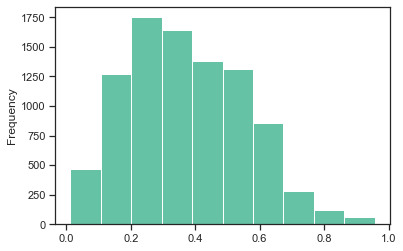

In [ ]:
y_df['TEperc'].plot(kind='hist')
plt.show()

In [ ]:
# Data from Bryan C Jensen et al, 2014 is pretty old
# We serched the ids in the table at TriTrypDB to get
# a mapping to more recent IDs
mapping_df = pd.read_csv('TE_gene_ids_mapping.csv')
mapping_df = mapping_df.drop_duplicates('Input ID')
mapping_df.columns = [n+'_mappend' for n in mapping_df.columns]
mapping_df.head()

,Gene ID_mappend,source_id_mappend,Organism_mappend,Genomic Location (Gene)_mappend,Product Description_mappend,Gene Type_mappend,Input ID_mappend
0,Tb04.24M18.150,Tb04.24M18.150:mRNA,Trypanosoma brucei brucei TREU927,"Tb927_04_v5.1:1,458,621..1,459,109(-)","hypothetical protein, conserved",protein coding,Tb04.24M18.150
1,Tb04.3I12.100,Tb04.3I12.100:mRNA,Trypanosoma brucei brucei TREU927,"Tb927_04_v5.1:1,312,814..1,313,406(-)",hypothetical protein,protein coding,Tb04.3I12.100
2,Tb05.30F7.410,Tb05.30F7.410:mRNA,Trypanosoma brucei brucei TREU927,"Tb927_05_v5.1:288,984..293,087(-)",hypothetical protein,protein coding,Tb05.30F7.410
3,Tb06.3A7.270,Tb06.3A7.270:mRNA,Trypanosoma brucei brucei TREU927,"Tb927_06_v5.1:389,986..393,393(-)","hypothetical protein, conserved",protein coding,Tb06.3A7.270
4,Tb06.3A7.960,Tb06.3A7.960:mRNA,Trypanosoma brucei brucei TREU927,"Tb927_06_v5.1:484,268..485,499(+)",hypothetical protein,protein coding,Tb06.3A7.960


In [ ]:
y_df = y_df.merge(mapping_df,left_on=['GeneID'],right_on=['Input ID_mappend'],how='left')
y_df.head()

,GeneID,Chromosome,CDS start,CDS end,PCF1r,PCF2r,PCF3r,slBF1r,slBF2r,slBF3r,...,Functional category,Prodcut description,TEperc,Gene ID_mappend,source_id_mappend,Organism_mappend,Genomic Location (Gene)_mappend,Product Description_mappend,Gene Type_mappend,Input ID_mappend
0,NCDS.Tb927.10.10451,Tb927_10_v5,2571650,2571312,1278.3,1658.6,1397.7,1862.0,1626.2,1686.0,...,DNA-associated,"histone H2B, putative",0.641274,Tb927.10.10445,Tb927.10.10445:mRNA,Trypanosoma brucei brucei TREU927,"Tb927_10_v5.1:2,571,305..2,571,705(-)","Core histone H2A/H2B/H3/H4, putative",protein coding,NCDS.Tb927.10.10451
1,NCDS.Tb927.10.13341,Tb927_10_v5,3257539,3257252,110.2,161.0,124.1,60.3,94.9,148.6,...,Unknown: conserved,"hypothetical protein, conserved",0.262791,Tb927.10.13335,Tb927.10.13335:mRNA,Trypanosoma brucei brucei TREU927,"Tb927_10_v5.1:3,257,252..3,257,725(-)","Zinc-finger of C2H2 type, putative",protein coding,NCDS.Tb927.10.13341
2,NCDS.Tb927.10.16121,Tb927_10_v5,3967640,3967744,25.5,34.2,32.6,35.8,23.2,23.9,...,Unknown: Tb-specific,hypothetical protein,0.449515,Tb927.10.16125,Tb927.10.16125:mRNA,Trypanosoma brucei brucei TREU927,"Tb927_10_v5.1:3,967,616..3,968,668(+)",hypothetical protein,protein coding,NCDS.Tb927.10.16121
3,NCDS.Tb927.10.8271,Tb927_10_v5,2051474,2051181,60.2,54.1,39.5,49.2,21.2,40.1,...,Unknown: Tb-specific,hypothetical protein,0.144553,Tb927.10.8275,Tb927.10.8275:mRNA,Trypanosoma brucei brucei TREU927,"Tb927_10_v5.1:2,051,009..2,051,480(-)","hypothetical protein, conserved",protein coding,NCDS.Tb927.10.8271
4,NCDS.Tb927.10.8291,Tb927_10_v5,2055119,2054826,69.8,60.7,40.9,53.5,26.3,45.7,...,Unknown: Tb-specific,hypothetical protein,0.170096,Tb927.10.8295,Tb927.10.8295:mRNA,Trypanosoma brucei brucei TREU927,"Tb927_10_v5.1:2,054,721..2,055,125(-)","hypothetical protein, conserved",protein coding,NCDS.Tb927.10.8291


In [ ]:
y_df = y_df[['Gene ID_mappend', 'TEperc']]

In [ ]:
print(df.shape)
df = df.merge(y_df,how='inner',left_on=['gene_id'],right_on=['Gene ID_mappend'])
print(df.shape)

(5871, 47)
(5777, 49)


In [ ]:
print(df.shape)
df=df.dropna(subset=['TEperc'])
print(df.shape)

(5777, 49)
(5777, 49)


In [ ]:
df.head()

,gene_id,utr_5,utr_3,utr_5_seq,utr_3_seq,utr_3_count_A,utr_3_count_T,utr_3_count_C,utr_3_count_G,utr_3_count_AT,...,utr_5_count_tracts_C_mismatch_1,utr_5_count_tracts_CT_mismatch_1,utr_5_count_tracts_AG_mismatch_1,utr_5_count_tracts_A_mismatch_0,utr_5_count_tracts_C_mismatch_0,utr_5_count_tracts_CT_mismatch_0,utr_5_count_tracts_AG_mismatch_0,utr_5_seq_len,Gene ID_mappend,TEperc
0,Tb927.9.13440,Tb927_09_v5.1:2132976..2133162:r,Tb927_09_v5.1:2127479..2128238:r,ATAGGGCAGAGATAAGAAAGAACAAAAGTGACTAACGTCATCGGAA...,CGGGAGCGGGAGAGTAATAACTAGAGAAAGAAAAGAAATAGAGGAC...,0.282895,0.303947,0.192105,0.221053,0.586842,...,0.0,0.000000,0.042781,0.000000,0.0,0.000000,0.058824,2.271842,Tb927.9.13440,0.596923
1,Tb927.9.13430,Tb927_09_v5.1:2126776..2127309:r,Tb927_09_v5.1:2121838..2125437:r,GGGAAGGTTCTCATTAAGCGGAAGATAGGGGGAACCAGACCCTCCA...,AGAATGATAATGATGGAGGGGTTGGGAAGAAGGGGGAGACATTTGT...,0.278889,0.417500,0.135833,0.167778,0.696389,...,0.0,0.022472,0.022472,0.000000,0.0,0.022472,0.026217,2.727541,Tb927.9.13430,0.611126
2,Tb927.9.13380,Tb927_09_v5.1:2120866..2121171:r,Tb927_09_v5.1:2118125..2119605:r,GAATCATTTTTAAAAAAAATTAGATTTGCAGTGTTGAAGTGTTTTC...,GTAATAATGGAAAAAAAAAAGAAGAATGGTGGGAGGAAGAAAAGGA...,0.274139,0.349088,0.154625,0.222147,0.623228,...,0.0,0.013072,0.022876,0.006536,0.0,0.013072,0.042484,2.485721,Tb927.9.13380,0.756651
3,Tb927.9.13360,Tb927_09_v5.1:2117171..2117516:r,Tb927_09_v5.1:2108712..2111431:r,TAACAACAAAGAGAATATATATCTCTAAATATATATTCATATATTT...,GTAATGTAGAAGGGCACTGTGCGATCAGTCTTGCTTTTTATTATTA...,0.336765,0.343750,0.151471,0.168015,0.680515,...,0.0,0.017341,0.005780,0.002890,0.0,0.017341,0.005780,2.539076,Tb927.9.13360,0.711857
4,Tb927.9.8905,Tb927_09_v5.1:1431796..1431807:r,Tb927_09_v5.1:1431368..1431516:r,GATATCGGCAGG,ACTTTTTGGCTGCCTCTTTCGCACCATTTTTTTGAGTTCGCGTTGT...,0.167785,0.449664,0.181208,0.201342,0.617450,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.079181,Tb927.9.8905,0.303394


## Visualize Correlations
we define a couple of function to visualize the correlation <br>
between the translation efficency and some features

In [ ]:
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error

#remove nan if present
def clean(pred, y_test):
    temp=pd.DataFrame()
    temp['pred']=pred
    temp['y_test']=y_test
    temp=temp.replace(-np.inf,np.nan).replace(np.inf,np.nan).dropna()
    return temp['pred'].values,temp['y_test'].values

#plot a regression line with some error
def abline(pred, y_test, ax, do_clean=True):
    if do_clean:
        
        pred, y_test = clean(pred, y_test)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(pred, y_test)
    """Plot a line from slope and intercept"""
    #axes = ax.get_gca()
    x_vals = np.array(ax.get_xlim())
    y_vals = intercept + slope * x_vals
    ax.plot(x_vals, y_vals, '--',c='r')
    MSE = mean_squared_error(pred, y_test)
    #r2 = r2_score(pred, y_test)
    r2=r_value**2
    p = pearsonr(pred, y_test)
    
    ax.text(0.01, 0.95, 'MSE: {:.4f}'.format(MSE), fontsize=12, transform=ax.transAxes)
    ax.text(0.01, 0.9, 'r2: {:.4f}'.format(r2), fontsize=12, transform=ax.transAxes)
    #ax.text(0.01, 0.85, 'corr: {:.4f}'.format(r_value), fontsize=12, transform=ax.transAxes)
    ax.text(0.01, 0.85, 'pearson: {:.4f}'.format(p[0]), fontsize=12, transform=ax.transAxes)
    
    #print('mean_squared_error',MSE)


In [ ]:
import seaborn as sns
sns.set(style='ticks', palette='Set2')
sns.despine()

<Figure size 432x288 with 0 Axes>

## Correletion of Translation Efficency with UTR length of 3'UTR

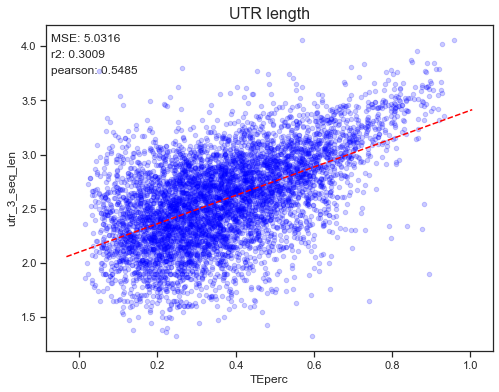

In [ ]:
import numpy as np
fig,ax=plt.subplots(figsize=(8,6))
df.plot(kind='scatter',x='TEperc',y='utr_3_seq_len',alpha=0.2,ax=ax,c='b')
abline(df['TEperc'], df['utr_3_seq_len'], ax)
ax.set_title('UTR length',fontsize=16)
plt.show()

## Correletion of Translation Efficency with C count of 3'UTR

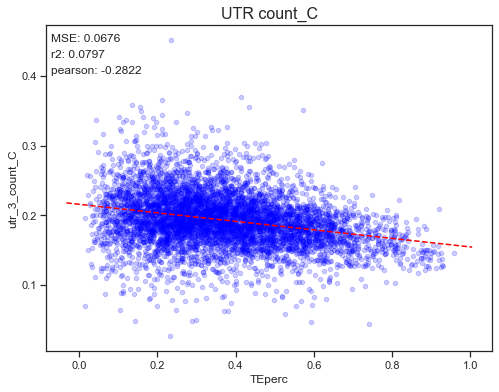

In [ ]:
fig,ax=plt.subplots(figsize=(8,6))
df.plot(kind='scatter',x='TEperc',y='utr_3_count_C',alpha=0.2,ax=ax,c='b')
abline(df['TEperc'], df['utr_3_count_C'], ax)
ax.set_title('UTR count_C',fontsize=16)
plt.show()

## Correletion of Translation Efficency with A count of 3'UTR

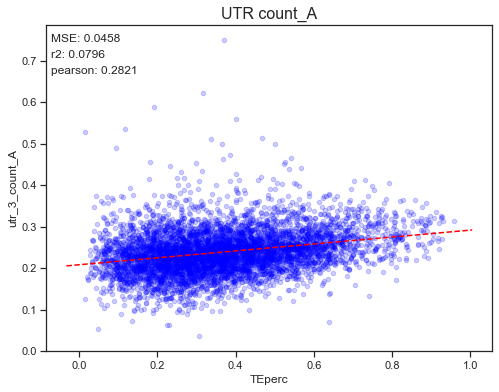

In [ ]:
fig,ax=plt.subplots(figsize=(8,6))
df.plot(kind='scatter',x='TEperc',y='utr_3_count_A',alpha=0.2,ax=ax,c='b')
abline(df['TEperc'], df['utr_3_count_A'], ax)
ax.set_title('UTR count_A',fontsize=16)
plt.show()

## Correletion of Translation Efficency with A count of 5'UTR

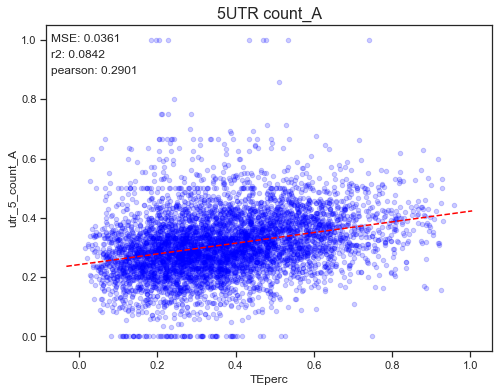

In [ ]:
fig,ax=plt.subplots(figsize=(8,6))
df.plot(kind='scatter',x='TEperc',y='utr_5_count_A',alpha=0.2,ax=ax,c='b')
abline(df['TEperc'], df['utr_5_count_A'], ax)
ax.set_title('5UTR count_A',fontsize=16)
plt.show()

In [ ]:
#list(np.array(df.columns))

In [ ]:
print(df.shape)
df=df.replace(-np.inf,np.nan)
df=df.replace(np.inf,np.nan)
df=df.dropna()
df.shape

(5777, 49)


(5722, 49)

In [ ]:
df.iloc[:,5:-2]

,utr_3_count_A,utr_3_count_T,utr_3_count_C,utr_3_count_G,utr_3_count_AT,utr_3_count_CG,utr_3_count_CT,utr_3_count_AG,utr_3_count_tracts_A_mismatch_2,utr_3_count_tracts_C_mismatch_2,...,utr_5_count_tracts_AG_mismatch_2,utr_5_count_tracts_A_mismatch_1,utr_5_count_tracts_C_mismatch_1,utr_5_count_tracts_CT_mismatch_1,utr_5_count_tracts_AG_mismatch_1,utr_5_count_tracts_A_mismatch_0,utr_5_count_tracts_C_mismatch_0,utr_5_count_tracts_CT_mismatch_0,utr_5_count_tracts_AG_mismatch_0,utr_5_seq_len
0,0.282895,0.303947,0.192105,0.221053,0.586842,0.413158,0.496053,0.503947,0.003947,0.001316,...,0.042781,0.000000,0.0,0.000000,0.042781,0.000000,0.0,0.000000,0.058824,2.271842
1,0.278889,0.417500,0.135833,0.167778,0.696389,0.303611,0.553333,0.446667,0.005556,0.002222,...,0.022472,0.000000,0.0,0.022472,0.022472,0.000000,0.0,0.022472,0.026217,2.727541
2,0.274139,0.349088,0.154625,0.222147,0.623228,0.376772,0.503714,0.496286,0.005402,0.000675,...,0.022876,0.006536,0.0,0.013072,0.022876,0.006536,0.0,0.013072,0.042484,2.485721
3,0.336765,0.343750,0.151471,0.168015,0.680515,0.319485,0.495221,0.504779,0.009191,0.000735,...,0.005780,0.002890,0.0,0.017341,0.005780,0.002890,0.0,0.017341,0.005780,2.539076
4,0.167785,0.449664,0.181208,0.201342,0.617450,0.382550,0.630872,0.369128,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.079181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5772,0.250000,0.338608,0.193038,0.218354,0.588608,0.411392,0.531646,0.468354,0.000000,0.000000,...,0.027132,0.019380,0.0,0.003876,0.034884,0.019380,0.0,0.003876,0.050388,2.411620
5773,0.240741,0.366667,0.185185,0.207407,0.607407,0.392593,0.551852,0.448148,0.000000,0.001235,...,0.034483,0.000000,0.0,0.000000,0.034483,0.000000,0.0,0.000000,0.034483,1.462398
5774,0.259574,0.291489,0.146809,0.302128,0.551064,0.448936,0.438298,0.561702,0.000000,0.000000,...,0.037209,0.018605,0.0,0.004651,0.041860,0.018605,0.0,0.004651,0.046512,2.332438
5775,0.226277,0.284672,0.160584,0.328467,0.510949,0.489051,0.445255,0.554745,0.000000,0.000000,...,0.022222,0.000000,0.0,0.000000,0.044444,0.000000,0.0,0.000000,0.044444,1.653213


# Random Forest Regressor
we train on 70% of the data and we evaluate on the other 30% <br>
we visualize the correlation between the Translation Efficency values and <br>
the predicted values with a scatter plot

In [ ]:
#df['TEperc'].plot(kind='hist')

(4005,) (1717,)


Text(0, 0.5, 'TE')

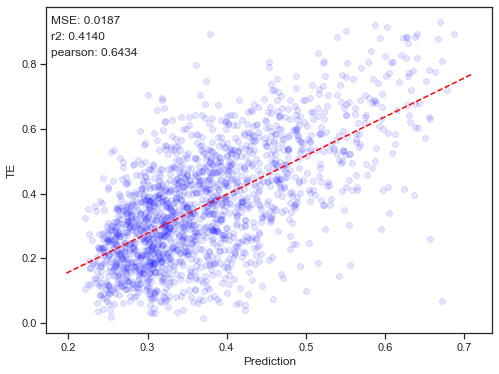

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X=df.iloc[:,5:-2] #

X=X.replace(-np.inf,np.nan)
X=X.replace(np.inf,np.nan)
X=X.fillna(X.mean())

y=df['TEperc']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(y_train.shape,y_test.shape)

regr = RandomForestRegressor(max_depth=5, 
                             n_estimators=100, 
                             min_samples_leaf=10, max_features=5)
regr.fit(X_train, y_train)
pred = regr.predict(X_test)


fig,ax=plt.subplots(figsize=(8,6))
ax.scatter(pred, y_test,c='blue',alpha=0.1)
abline(pred, y_test, ax, do_clean=False)
ax.set_xlabel('Prediction')
ax.set_ylabel('TE')

## shap values to rank feature importance

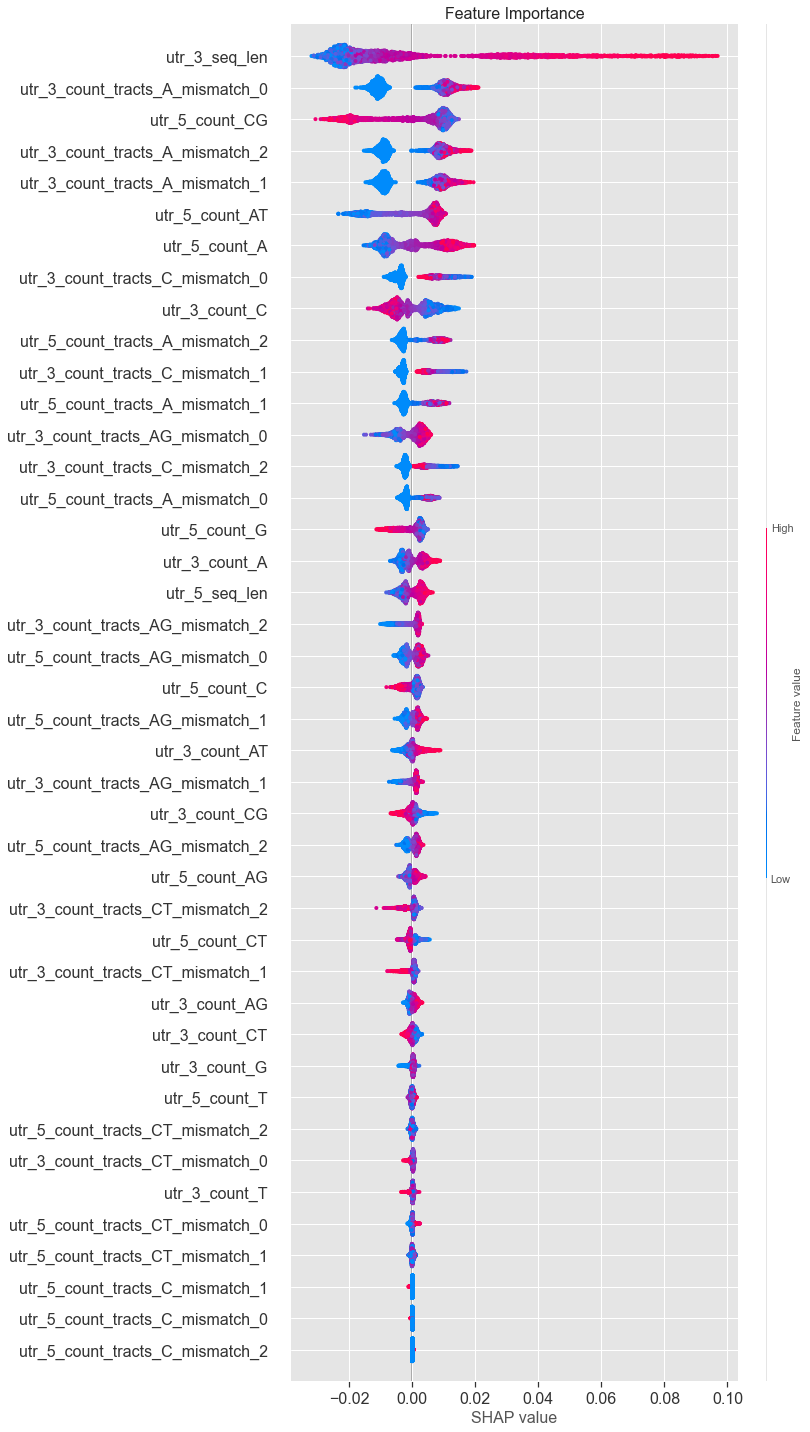

In [ ]:
import shap
#Now we use the SHAP scoring system to visualise 
#the most important features for the model
explainer = shap.TreeExplainer(regr)
shap_values = explainer.shap_values(X_train)

plt.style.use('ggplot')
shap.summary_plot(shap_values, 
                  X_train, 
                  feature_names=list(X_train.columns),
                  max_display=100,show=False)

f = plt.gcf()
f.set_size_inches(12,20)
plt.title('Feature Importance',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('SHAP value',fontsize=16)
plt.tight_layout()

In [ ]:
# removing correleted features generally improves the model
cor_matrix = X.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
print(to_drop)

['utr_3_count_CG', 'utr_3_count_AG', 'utr_3_count_tracts_A_mismatch_1', 'utr_3_count_tracts_C_mismatch_1', 'utr_3_count_tracts_CT_mismatch_1', 'utr_3_count_tracts_AG_mismatch_1', 'utr_3_count_tracts_A_mismatch_0', 'utr_3_count_tracts_C_mismatch_0', 'utr_3_count_tracts_AG_mismatch_0', 'utr_5_count_CG', 'utr_5_count_AG', 'utr_5_count_tracts_A_mismatch_1', 'utr_5_count_tracts_C_mismatch_1', 'utr_5_count_tracts_CT_mismatch_1', 'utr_5_count_tracts_AG_mismatch_1', 'utr_5_count_tracts_A_mismatch_0', 'utr_5_count_tracts_C_mismatch_0', 'utr_5_count_tracts_CT_mismatch_0', 'utr_5_count_tracts_AG_mismatch_0']


`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [ ]:
X = X.drop(X[to_drop], axis=1)

In [ ]:
X.shape

(5722, 23)

(4005,) (1717,)


Text(0, 0.5, 'TEperc')

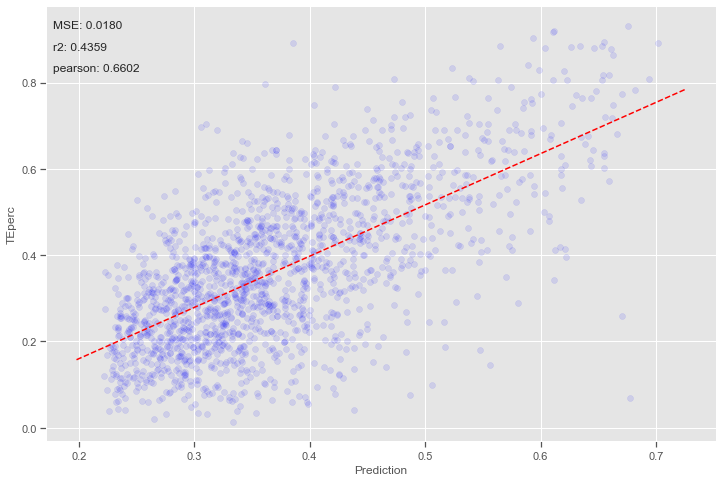

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


y=df['TEperc']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(y_train.shape,y_test.shape)

regr = RandomForestRegressor(max_depth=5, 
                             n_estimators=100, 
                             min_samples_leaf=10, max_features=5)
regr.fit(X_train, y_train)
pred = regr.predict(X_test)


fig,ax=plt.subplots(figsize=(12,8))
ax.scatter(pred, y_test,c='blue',alpha=0.1)
abline(pred, y_test, ax, do_clean=False)
ax.set_xlabel('Prediction')
ax.set_ylabel('TEperc')

## eli5 to rank the feture importance 


In [ ]:
from eli5.sklearn import PermutationImportance
import eli5
perm = PermutationImportance(regr, random_state=42, n_iter=10)


perm.fit(X_test, y_test.values, cv=3)           
    #visualize the output
n = eli5.show_weights(perm, feature_names = list(X_test.columns), 
                  top=500, show_feature_values=True)
    
eliDf = pd.DataFrame()
eliDf['fimp']=perm.feature_importances_
eliDf['f']=X.columns

In [ ]:
eliDf.sort_values(by='fimp',ascending=False).head(10)

,fimp,f
11,0.184561,utr_3_seq_len
16,0.040835,utr_5_count_AT
6,0.034704,utr_3_count_tracts_A_mismatch_2
2,0.021614,utr_3_count_C
12,0.020278,utr_5_count_A
7,0.013219,utr_3_count_tracts_C_mismatch_2
22,0.008271,utr_5_seq_len
0,0.007012,utr_3_count_A
9,0.005339,utr_3_count_tracts_AG_mismatch_2
15,0.004324,utr_5_count_G


In [ ]:
eliDf.sort_values(by='fimp',ascending=False).tail(10)

,fimp,f
5,0.002595,utr_3_count_CT
18,0.002215,utr_5_count_tracts_A_mismatch_2
21,0.001788,utr_5_count_tracts_AG_mismatch_2
3,0.001268,utr_3_count_G
17,0.001077,utr_5_count_CT
10,0.000686,utr_3_count_tracts_CT_mismatch_0
13,0.000434,utr_5_count_T
1,0.000421,utr_3_count_T
19,0.000065,utr_5_count_tracts_C_mismatch_2
20,0.000004,utr_5_count_tracts_CT_mismatch_2


Text(0, 0.5, 'TE')

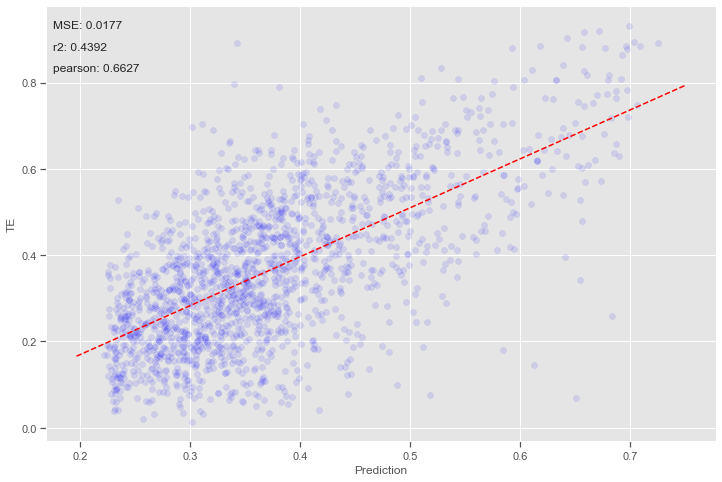

In [ ]:
# we use to top 10 features found by eli5
X=df[ list(eliDf.sort_values(by='fimp',ascending=False)['f'].values)[0:10] ]

#X=X.replace(-np.inf,np.nan)
#X=X.replace(np.inf,np.nan)
#X=X.fillna(X.mean())
y=df['TEperc']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#print(y_train.shape,y_test.shape)

regr = RandomForestRegressor(max_depth=4, 
                             n_estimators=100, 
                             min_samples_leaf=20, 
                             max_features=4,n_jobs=6,
                             random_state=42)
regr.fit(X_train, y_train)
pred = regr.predict(X_test)


fig,ax=plt.subplots(figsize=(12,8))
ax.scatter(pred, y_test,c='blue',alpha=0.1)
abline(pred, y_test, ax, do_clean=False)
ax.set_xlabel('Prediction')
ax.set_ylabel('TE')

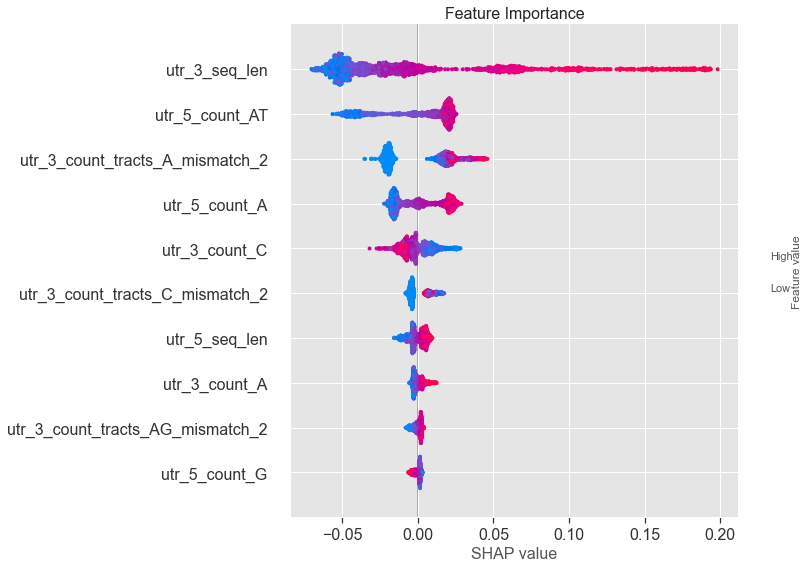

In [ ]:
import shap
#Now we use the SHAP scoring system to visualise 
#the most important features for the model
explainer = shap.TreeExplainer(regr)
shap_values = explainer.shap_values(X_test)
#shap.summary_plot(shap_values, 
                  #train[train_features],
                  #max_display=100)

plt.style.use('ggplot')
shap.summary_plot(shap_values, 
                  X_test, 
                  feature_names=list(X_test.columns),
                  max_display=100,show=False)

f = plt.gcf()
f.set_size_inches(12,8)
plt.title('Feature Importance',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('SHAP value',fontsize=16)
plt.tight_layout()

In [ ]:
# show versions of packages
# adopted from https://stackoverflow.com/questions/40428931/package-for-listing-version-of-packages-used-in-a-jupyter-notebook
import pkg_resources
import types
import sys
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]
        elif isinstance(val, type):
            name = val.__module__.split(".")[0]
        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]
        yield name.lower()
imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
modules = []
for m in sys.builtin_module_names:
    if m.lower() in imports and m !='builtins':
        modules.append((m,'Python BuiltIn'))
        imports.remove(m.lower())

for m in pkg_resources.working_set:
    if m.project_name.lower() in imports and m.project_name!="pip":
        modules.append((m.project_name, m.version))
        imports.remove(m.project_name.lower())

for m in sys.modules:
    if m.lower() in imports and m !='builtins':
        modules.append((m,'unknown'))

# print('System=='+platform.system()+' '+platform.release()+'; Version=='+platform.version())
for r in modules:
    if 'unknown' in r[1]:
        continue
    print("{}=={}".format(*r))

sys==Python BuiltIn
matplotlib==3.5.1
numpy==1.21.6
scipy==1.10.1
pandas==1.4.2
scikit-learn==1.0.2
shap==0.39.0
eli5==0.13.0
seaborn==0.11.2


In [ ]:
!python --version

Python 3.10.10
